In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

print(torch.cuda.device_count())

2


In [2]:
import pickle
import json

dataset = "electricity"
model_name = "forecasting_electricity_"
datafolder = model_name + "20240527_174213"  # set the folder name
nsample = 2  # number of generated sample


In [6]:
path_result = "./models_save/" + datafolder + "/result_" + str(nsample) + "samples.json"
with open(path_result, "r", encoding="utf-8") as file:
    json_str = file.read()
result = json.loads(json_str)
print(result)

{'epochs': 2, 'batch_size': 64, 'learning rate': 0.001, 'lengths': [2521, 5, 7], 'RMSE': 4133.740186038284, 'MAE': 465.5076138856627, 'CRPS': 0.5526335866827714, 'CRPS_sum': 0.42056128853245783}


In [7]:
path_outputs = (
    "./models_save/" + datafolder + "/generated_outputs_" + str(nsample) + "samples.pk"
)

with open(path_outputs, "rb") as f:
    (
        samples,
        all_target,
        all_evalpoint,
        all_observed,
        all_observed_time,
        scaler,
        mean_scaler,
    ) = pickle.load(f)


all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1]  # feature
L = samples.shape[-2]  # time length

print("特征数量: ", K)
print("序列长度: ", L)

特征数量:  370
序列长度:  192


In [8]:
samples[0][1][0][0]

tensor(28.0249, device='cuda:1')

In [9]:
def get_quantile(samples, q, dim=1):
    return torch.quantile(samples, q, dim=dim).cpu().numpy()


qlist = [0.05, 0.25, 0.5, 0.75, 0.95]
quantiles_imp = []
for q in qlist:
    quantiles_imp.append(
        get_quantile(samples, q, dim=1) * (1 - all_given_np)
        + all_target_np * all_given_np
    )

IndexError: index 9 is out of bounds for axis 0 with size 9

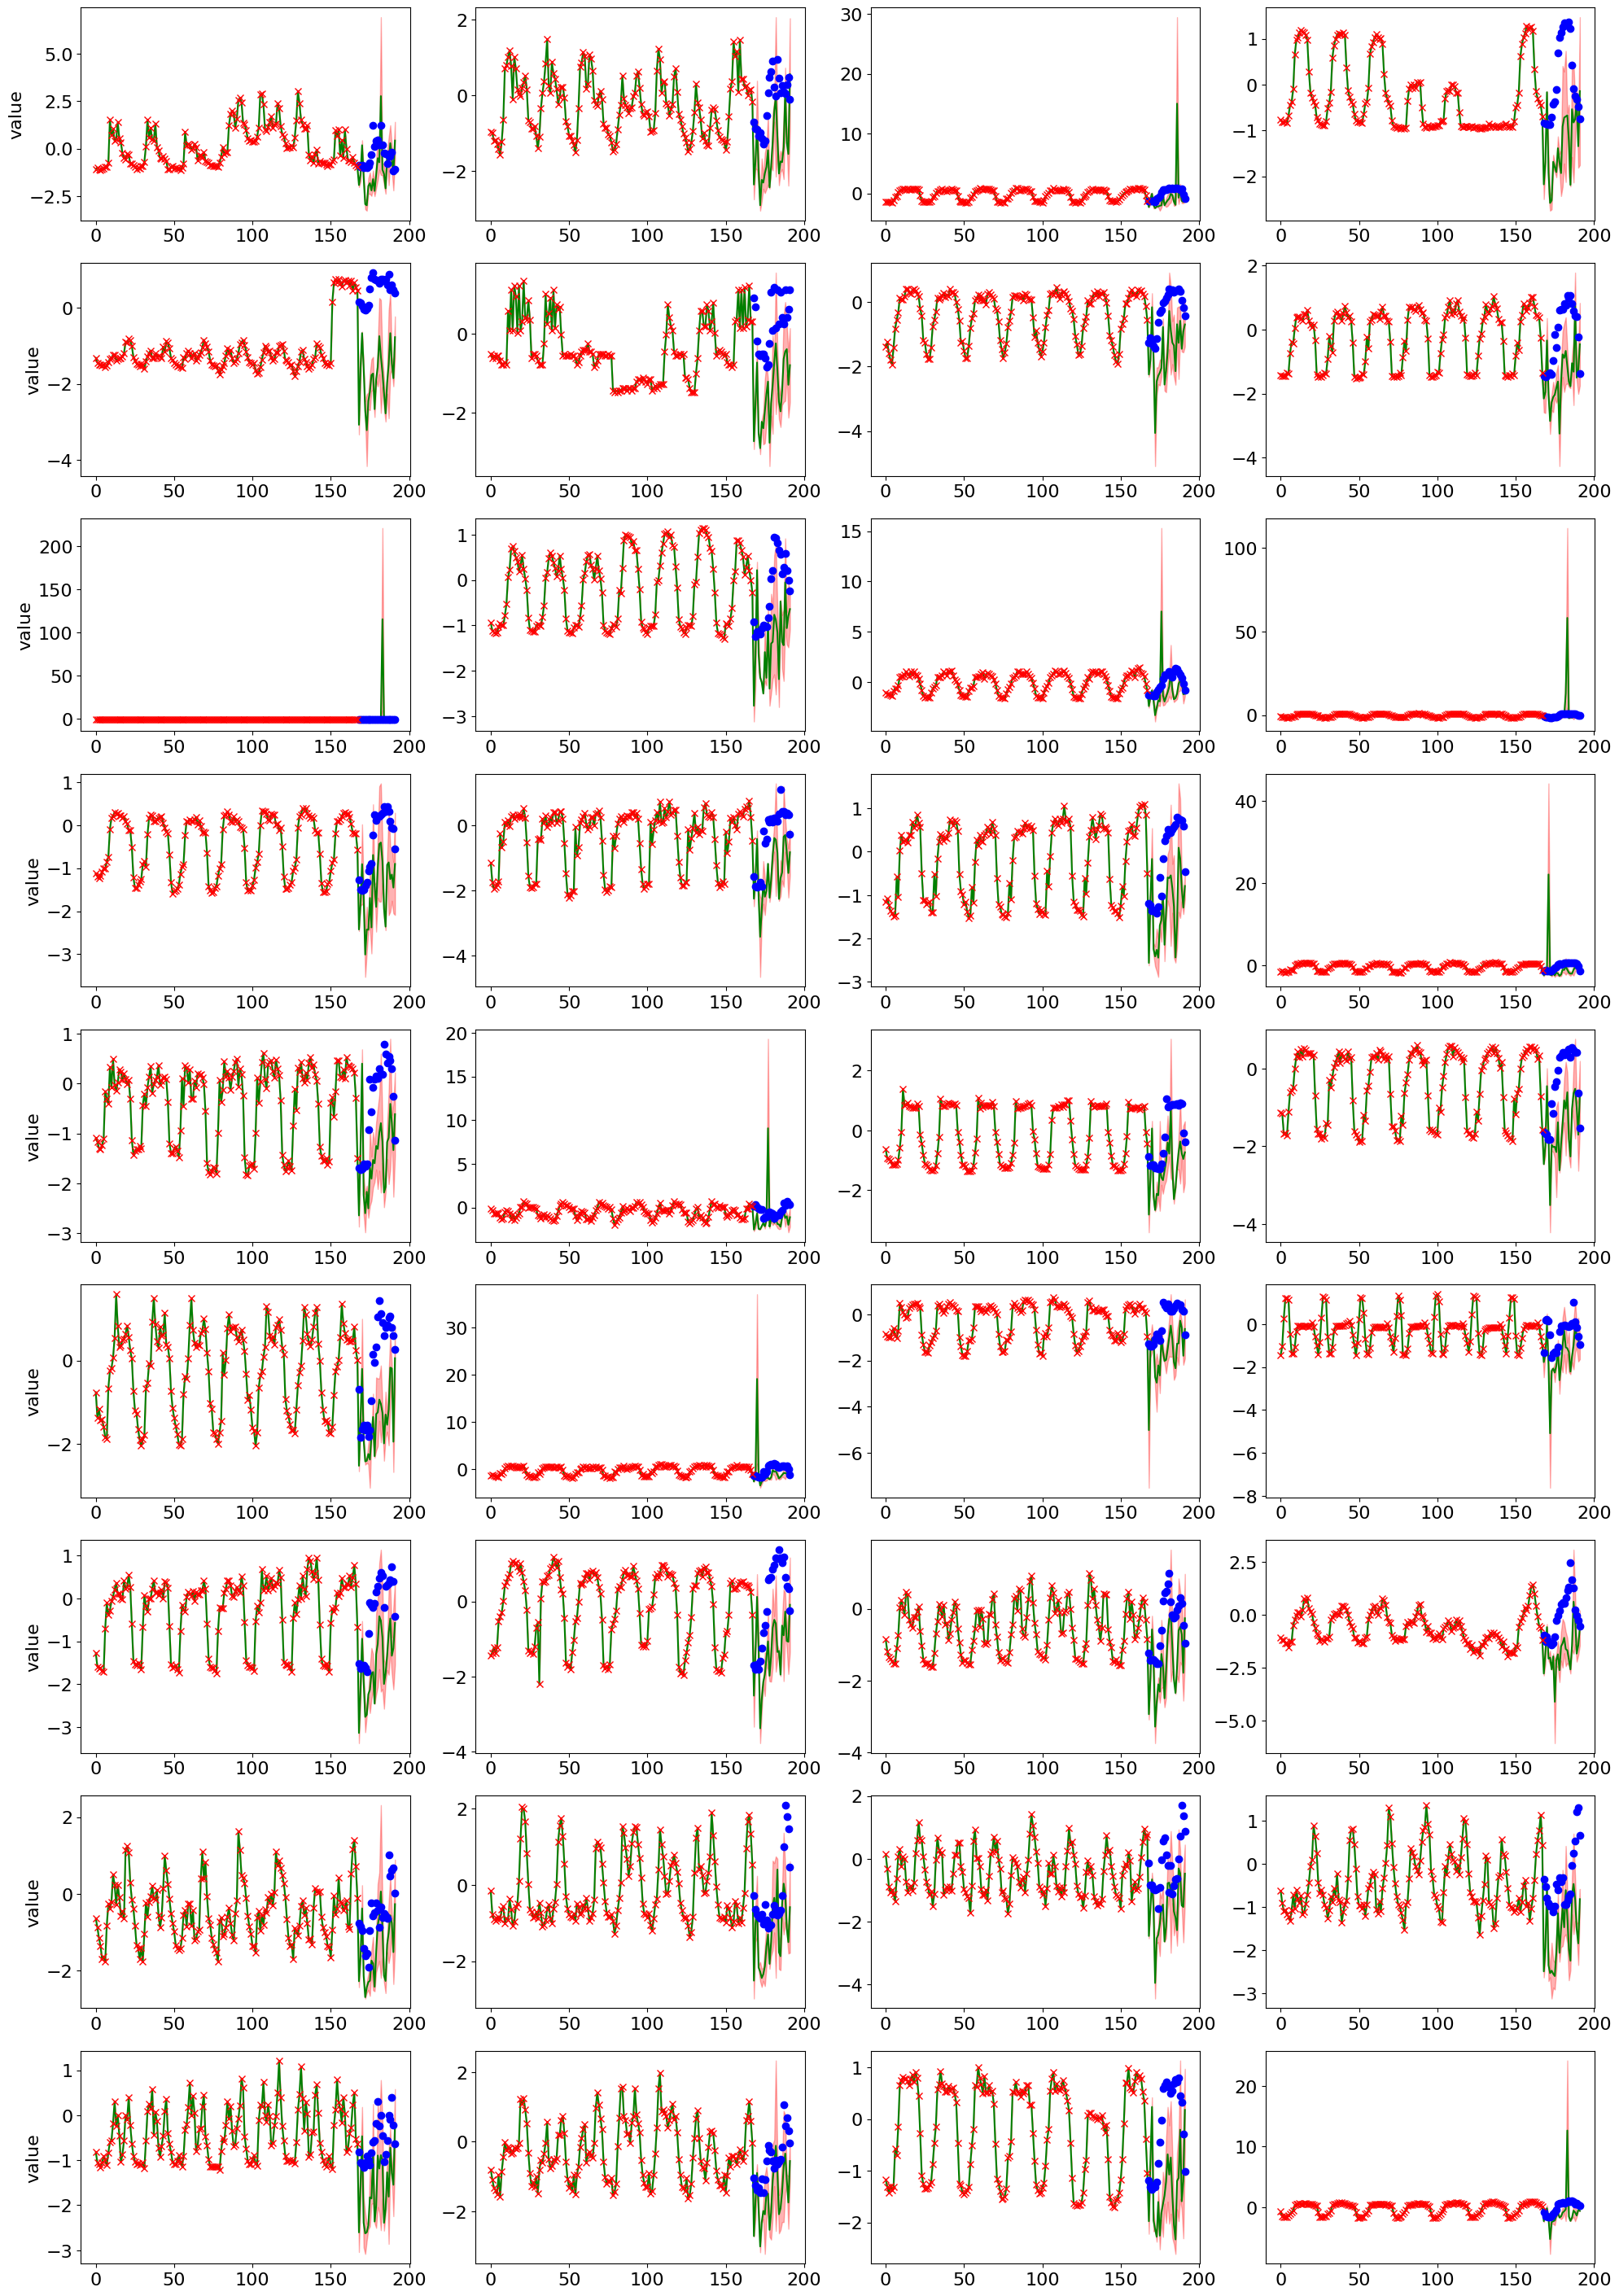

In [10]:
###electricity###
dataind = 0  # 0~6,表示一周的七天预测数据


plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(24.0, 36.0))
# 计算需要删除的多余子图数量
extra_plots = 9 * 4 - K
for i in range(extra_plots):
    fig.delaxes(axes.flatten()[-1 - i])

for k in range(K):
    df = pd.DataFrame(
        {
            "x": np.arange(0, L),
            "val": all_target_np[dataind, :, k],
            "y": all_evalpoint_np[dataind, :, k],
        }
    )
    df = df[df.y != 0]
    df2 = pd.DataFrame(
        {
            "x": np.arange(0, L),
            "val": all_target_np[dataind, :, k],
            "y": all_given_np[dataind, :, k],
        }
    )
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(
        range(0, L),
        quantiles_imp[2][dataind, :, k],
        color="g",
        linestyle="solid",
        label="CSDI",
    )
    axes[row][col].fill_between(
        range(0, L),
        quantiles_imp[0][dataind, :, k],
        quantiles_imp[4][dataind, :, k],
        color="r",
        alpha=0.3,
    )
    axes[row][col].plot(df.x, df.val, color="b", marker="o", linestyle="None")
    axes[row][col].plot(df2.x, df2.val, color="r", marker="x", linestyle="None")
    if col == 0:
        plt.setp(axes[row, 0], ylabel="value")
    if row == -1:
        plt.setp(axes[-1, col], xlabel="time")
"""

当row= k//4时: 下图共24个蓝点, 代表预测的一天24小时的结果
"""